# Explaining a ML Model using Shapley Values

- In this notebook we explain ML models using the classic framework from game theory, known as Shapley values. This is based on the work from 1951 by game theorist Lloyd Shapley. The original paper is here: https://www.rand.org/content/dam/rand/pubs/research_memoranda/2008/RM670.pdf

- See also the Wikipedia entry that is brief and easy to read: https://en.wikipedia.org/wiki/Shapley_value

- More recently, the idea has been adopted in computer science to explain ML models, and the paper that launched this idea is the one by Scott Lundberg and Su-In Lee, see: https://arxiv.org/abs/1705.07874

- This led to a widely-used open source repository called SHAP: https://github.com/slundberg/shap (this was Lundberg's PhD thesis at UW)

- It is part of a broader area on machine learning "interpretability". For a very good exposition of ML explainability, see the wonderful little online book by Christoph Molnar: https://christophm.github.io/interpretable-ml-book/

In [1]:
%%time
# %%capture
!pip install --upgrade pip --quiet
!pip install --upgrade setuptools --quiet

# MXNet version of AutoGluon (deprecated)
# !pip install --upgrade "mxnet_cu110<2.0.0"
# !pip install autogluon==0.1.0

# CPU version of pytorch has smaller footprint - see installation instructions in
# pytorch documentation - https://pytorch.org/get-started/locally/
# !pip3 install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchtext==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu113
# !pip3 install torch==1.12+cpu torchvision==0.13.0+cpu torchtext==0.13.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html --quiet
!pip3 install autogluon --quiet

!pip install --upgrade shap --quiet

CPU times: user 194 ms, sys: 38.8 ms, total: 233 ms
Wall time: 28.4 s


In [2]:
%pylab inline
import pandas as pd
from typing import Callable, Iterable
import numpy as np
import scipy.special
import itertools
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


In [3]:
from google.colab import drive
drive.mount('/content/drive')  # Add My Drive/<>

import os
os.chdir('drive/My Drive')
os.chdir('Books_Writings/NLPBook/')

Mounted at /content/drive


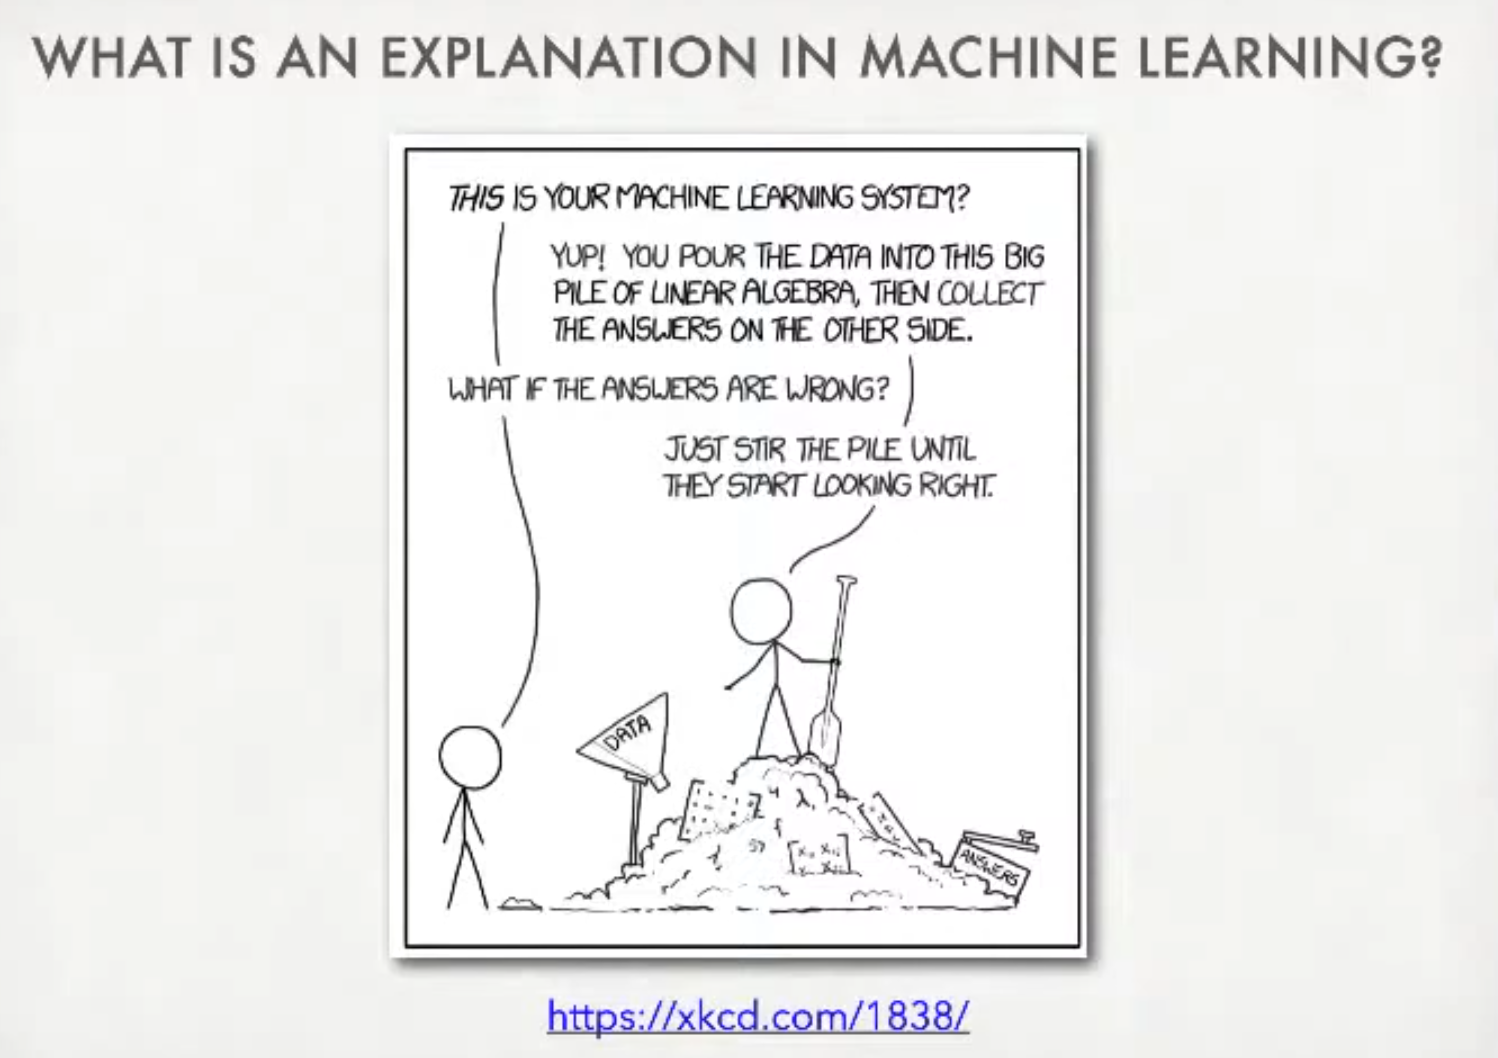

In [4]:
Image("NLP_images/xai.png", width=700)

## Origins of Shapley value

Shapley values quantify the contribution of each player to a game, and hence provide the means to distribute the total payoff generated by a game to its players based on their contributions.

Let's take an example of $M=3$ (players $P_1, P_2, P_3$) or students in a group project for which the total score achieved was 100. How do we allocate credit to each student?

We examine all possible groupings of the players, and in this case there are 8 such groupings: $\emptyset$, $\{P_1\}$, $\{P_2\}$, $\{P_3\}$, $\{P_1, P_2\}$, $\{P_1, P_3\}$, $\{P_2, P_3\}$, $\{P_1, P_2, P_3\}$.

We assume the outcomes are: $5,10,15,12,45,55,65,100$.

Now we can compute the probability of a subset $S$ that does not contain one of the players. The notation $|S|$ stands for the size of the set $S$.

$$
Pr  = \frac{|S|! (M-|S|-1)!}{(M-1)!} \times \frac{1}{M} = \frac{|S|! (M-|S|-1)!}{M!}
$$

In [5]:
from math import factorial
M = 3
# For P1, subsets are [null, P2, P3, {P2,P3}]
# Size |S| = 0,1,1,2
size_S = [0,1,1,2]
pr_S = [factorial(j)*factorial(M-j-1)/factorial(M) for j in size_S]
payoff = [5,30,43,35]
P1_payoff = sum([x*y for x,y in zip(pr_S,payoff)])
print(pr_S, payoff, P1_payoff)


[0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333] [5, 30, 43, 35] 25.5


In [6]:
# For P2, subsets are null, P1, P3, {P1,P3}
# Size |S| = 1,1,1,2
size_S = [0,1,1,2]
pr_S = [factorial(j)*factorial(M-j-1)/factorial(M) for j in size_S]
payoff = [10,35,53,45]
P2_payoff = sum([x*y for x,y in zip(pr_S,payoff)])
print(pr_S, payoff, P2_payoff)

[0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333] [10, 35, 53, 45] 33.0


In [7]:
# For P3, subsets are null, P1, P2, {P1,P2}
# Size |S| = 1,1,1,2
size_S = [0,1,1,2]
pr_S = [factorial(j)*factorial(M-j-1)/factorial(M) for j in size_S]
payoff = [7,45,50,55]
P3_payoff = sum([x*y for x,y in zip(pr_S,payoff)])
print(pr_S, payoff, P3_payoff)

print("Check additivity =",P1_payoff + P2_payoff + P3_payoff)

[0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333] [7, 45, 50, 55] 36.5
Check additivity = 95.0


This shows the required number, i.e., productivity of all 3 players versus no players, 100-5 = 95.

## Shapley value math (from the SHAP paper)

Here we note some differences between the original paper by Shapley and the implementation in the recent SHAP paper.

Some notation:
- Feature set: $x = \{x_1,x_2,...,x_M\}$
- $S$: subset of $x$
- Power set of all feature subsets: $P = \{\emptyset,\{x_1\},\{x_2\},...,x\}$
- $|P| = 2^M$, so if $M=4$, then $|P|=16$.
- $f(S)$: predicted value from the fitted model function $f$, using a subset $S$ of the features

The Lunderberg and Lee (2017) paper (https://arxiv.org/pdf/1705.07874) adjusts the Shapley value for feature $i$ (see Theorem 2 in the paper):

$$
SHAP(x_i) = \phi_i = \sum_{S \subset P \setminus x_i} \frac{M-1}{{M \choose |S|} \cdot |S| \cdot (M-|S|)} [f(S \cup x_i)-f(S)]
$$


So, the SHAP kernel is the weighting function:

$$
k_{SHAP} = \frac{M-1}{{M \choose |S|} \cdot |S| \cdot (M-|S|)}
$$



The original "classic" Shapley kernel we saw above is

$$
k_{Shapley} = \frac{|S|! (M-|S|-1)!}{M!}
$$

Therefore,

$$
k_{SHAP} = k_{Shapley} \cdot \frac{M-1}{|S|}
$$

Next see some code that implements these kernels as functions.

## Transfer these ideas to ML models

- Let the features be players in the game and see how the various combinations of features change the predicted value from the model. If leaving out a feature does not change the prediction a lot, the Shapley value will be small and it is clear that the feature is not important.

- Because the size of the powerset grows very fast, we can take samples of coalitions and work out the marginal contributions from the samples. To do this we need to specify the baseline and the number of samples.

In [8]:
# Helper functions

# See Theorem 2 in the original Shapley explanations paper: https://arxiv.org/pdf/1705.07874.pdf
def shapley_kernel(M: int, s: int) -> float:
    if s == 0 or s == M:
        return 10000  # Because the Shapley kernel is infinity for the null set or full set
    return (M - 1) / (scipy.special.binom(M, s) * s * (M - s))

# Classic Shapley kernel, not the same as Lundberg's kernel above by a factor of (M-1)/s
def classic_kernel(M: int, s: int) -> float:
    if s == 0 or s == M:
        return 10000
    return factorial(s)*factorial(M-s-1)/factorial(M)

def powerset(xs: Iterable) -> Iterable:
    """
    :returns: iterable of subsets of xs
    """
    s = list(xs)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s) + 1))

## Compare the weights between the Shapley and Classic kernels

0 () 10000 10000
1 (1,) 0.25 0.0833
2 (2,) 0.25 0.0833
3 (3,) 0.25 0.0833
4 (4,) 0.25 0.0833
5 (1, 2) 0.125 0.0833
6 (1, 3) 0.125 0.0833
7 (1, 4) 0.125 0.0833
8 (2, 3) 0.125 0.0833
9 (2, 4) 0.125 0.0833
10 (3, 4) 0.125 0.0833
11 (1, 2, 3) 0.25 0.25
12 (1, 2, 4) 0.25 0.25
13 (1, 3, 4) 0.25 0.25
14 (2, 3, 4) 0.25 0.25
15 (1, 2, 3, 4) 10000 10000


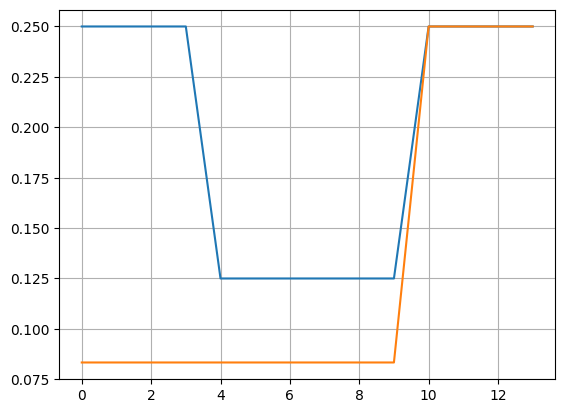

In [9]:
from math import factorial
xs = array([1,2,3,4])
P = enumerate(powerset(xs))
wts1 = []
wts2 = []
for i, s in P:
    w1 = shapley_kernel(len(xs), len(s))
    w2 = classic_kernel(len(xs), len(s))
    wts1 = append(wts1, w1)
    wts2 = append(wts2, w2)
    print(i, s, round(w1,4), round(w2,4))
plot(wts1[1:-1]); grid()
plot(wts2[1:-1])

## Three Axioms

1. Dummy feature: If a feature never adds any marginal explanation, its payoff is zero.

2. Substitutability: If two features always add the same marginal value to any subset to which they are added, their payoff should be the same

3. Additivity: The payoff of a feature in two subsets of features should be additive to the sum of the payoffs in the combined set.

Shapley value is the only attribution method that satisfies these axioms.

## Surrogate and Locally Interpretable Models

- In the literature, beginning with the LIME model, see https://homes.cs.washington.edu/~marcotcr/blog/lime/, the concept of locally interpretable models was floated. The idea being that feature importance can be different in various neighborhoods of the feature space.

- The model may be trustworthy locally even if not globally.

- We want the explanations to be model agnostic. Therefore, we fit linear surrogates.

## The Main SHAP function

In which we implement the entire SHAP in just 20 lines.

We will return to this after we break down the algorithm into its components and understand each part of it.

In [10]:
# One function to rule it all

def model(x):
        return np.dot(x, model_params) + bias

def kernel_shap(model: Callable[[np.ndarray], np.ndarray], instance: np.array, reference: np.array, M: int) -> np.array:
    n_samples = 2 ** M
    simplified_features = np.zeros((n_samples, M + 1))
    simplified_features[:, -1] = 1  # last is all features set
    kernel_weights = np.zeros(n_samples)
    synthetic_dataset = np.zeros((n_samples, M))
    for i in range(n_samples):
        synthetic_dataset[i, :] = reference
    for i, subset in enumerate(powerset(range(M))):
        subset = list(subset)
        simplified_features[i, subset] = 1
        synthetic_dataset[i, subset] = instance[subset]
        kernel_weights[i] = shapley_kernel(M, len(subset)) # you can also use the classic_kernel
    # Solve:
    y = model(synthetic_dataset)
    W = np.diag(kernel_weights)
    xtwxm1 = np.linalg.inv(np.dot(np.dot(simplified_features.T, W), simplified_features))
#     tmp = np.dot(simplified_features.T, W)  # This line is not needed
    res = np.dot(xtwxm1, np.dot(np.dot(simplified_features.T, W), y))
    return res

## Read in the iris data set

Let's do the above in small pieces using the iris data set.

In [11]:
iris = pd.read_csv('NLP_data/iris_data.csv')
print(iris.shape)
M = iris.shape[1] - 1
iris.head()

(150, 5)


sepal.length  sepal.width  petal.length  petal.width variety
0           5.1          3.5           1.4          0.2  Setosa
1           4.9          3.0           1.4          0.2  Setosa
2           4.7          3.2           1.3          0.2  Setosa
3           4.6          3.1           1.5          0.2  Setosa
4           5.0          3.6           1.4          0.2  Setosa

## Diagrammatic Exposition of the Matrices and Vectors in SHAP

Steps to understand the SHAP algorithm:
1. Assume we have a complex black-box model for which we want feature importances.
2. The idea is to find a linear model to approximate the black-box model.
3. First, fit the linear model to generated values from the black-box model for all permutations of the feature set (which we call the synthetic dataset).
4. We call the black-box model $2^{|M|}$ times -- this can be onerous because the number of permutations can grow as $M$ gets large so a sampling approach is applied.
5. The weighted regression is fitted to get the Shapley values. Weights are the kernel weights.

We see the sketch first below and then the code to fit it.

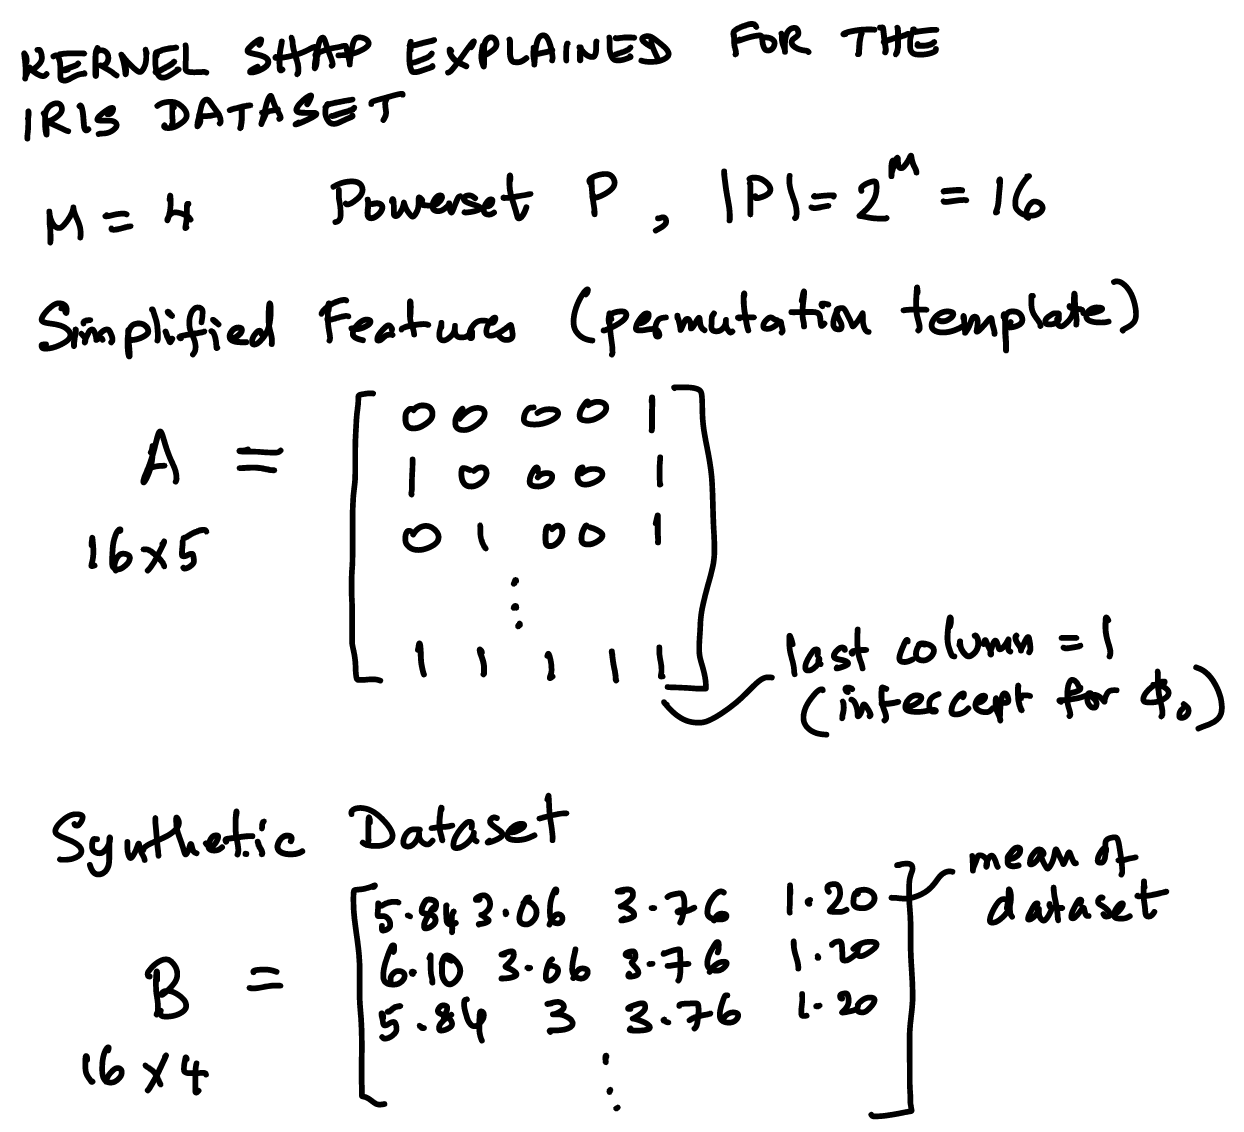

In [12]:
Image("NLP_images/pshap1.png",width=500)

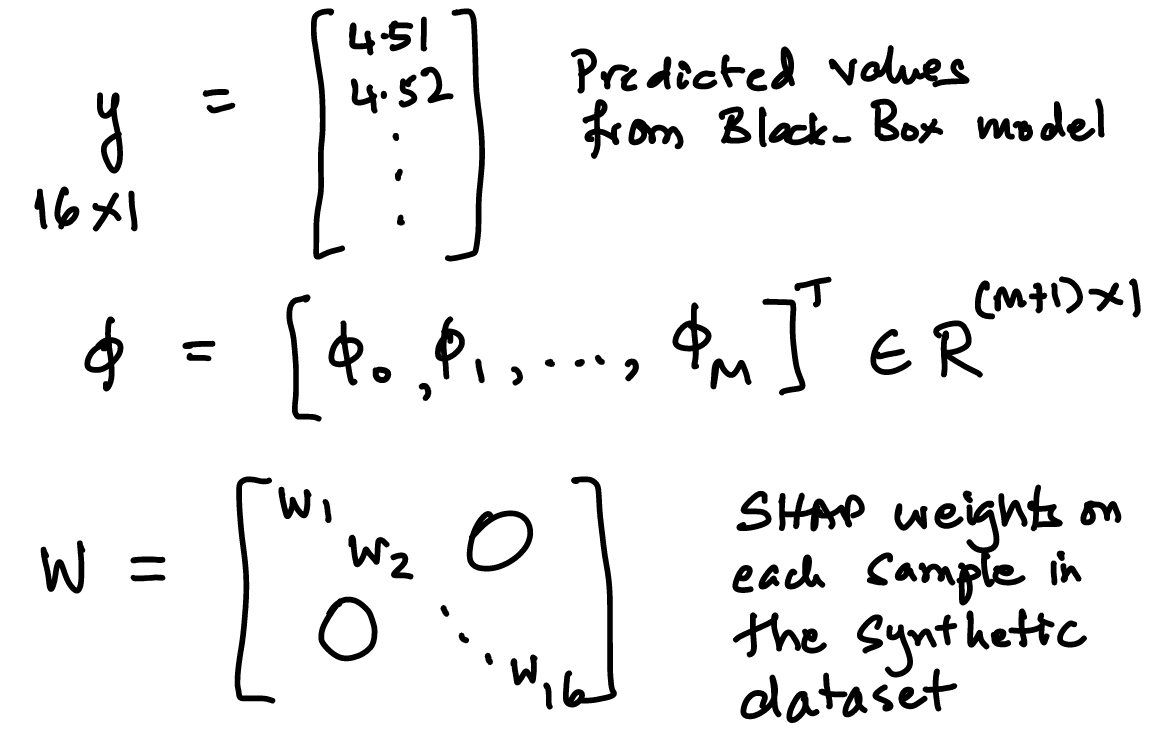

In [13]:
Image("NLP_images/pshap2.png",width=500)

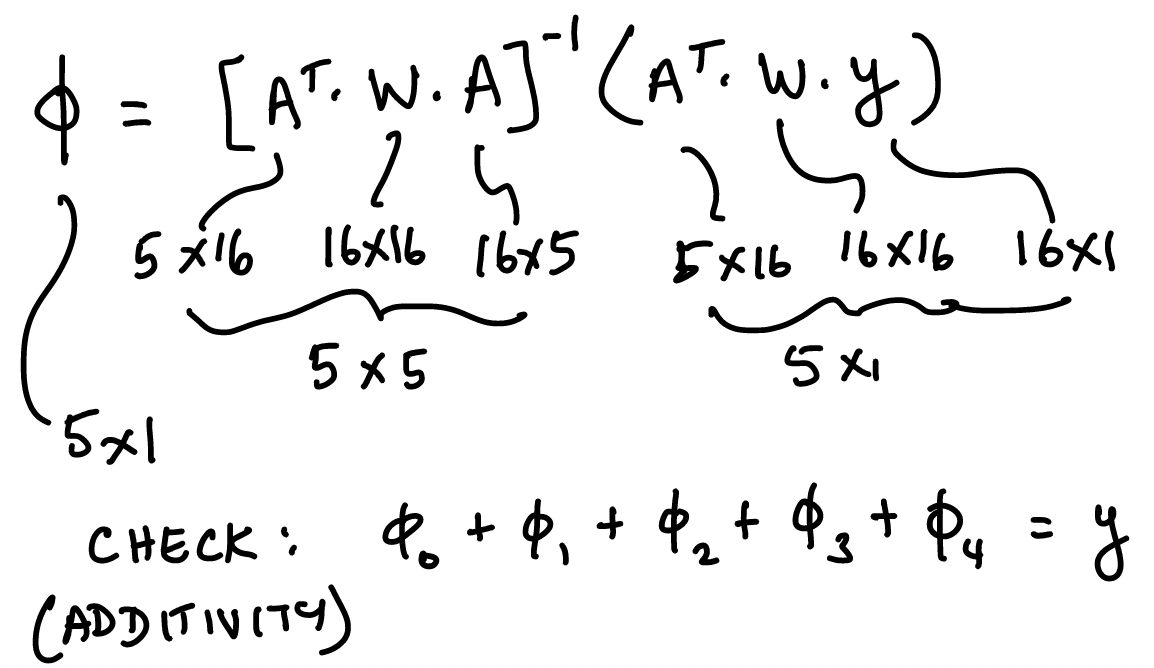

In [14]:
Image("NLP_images/pshap3.png",width=500)

## Powerset and samples

Number of sample is $n$, and the size of the powerset is also $n$ if we enumerate all subsets. However, in practice we may choose a smaller sample size than $n$.

In [15]:
# Get the size of the powerset
n_samples = 2**M
print(n_samples)

16


## Simplified features

We call this matrix $A$ and each column is for the different SHAP values $\phi_i, i=1..M$ and also one for the constant, $\phi_0$.

$$
A \in {R}^{n \times (M+1)}
$$

In [16]:
# Simplified features
simplified_features = np.zeros((n_samples, M + 1))
simplified_features[:, -1] = 1  # intercept
print(simplified_features.shape)
simplified_features

(16, 5)


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

## Kernel weights and Synthetic dataset

The SHAP kernel was shown above and is of dimension $n$ also, but later we will store the values of the kernel weights in a $n \times n$ matrix, denoted $W$.

The synthetic dataset is denoted $B$, for "background" dataset.

In [17]:
# Set up kernel weights and the synthetic dataset
kernel_weights = np.zeros(n_samples)
synthetic_dataset = np.zeros((n_samples, M))
print(synthetic_dataset.shape)
synthetic_dataset

(16, 4)


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

## Reference observation or baseline instance

This is the benchmark from which we want to explain the deviation of the instance we are trying to explain. Here we set the reference to the mean of the dataset.

In [18]:
iris.head()

sepal.length  sepal.width  petal.length  petal.width variety
0           5.1          3.5           1.4          0.2  Setosa
1           4.9          3.0           1.4          0.2  Setosa
2           4.7          3.2           1.3          0.2  Setosa
3           4.6          3.1           1.5          0.2  Setosa
4           5.0          3.6           1.4          0.2  Setosa

In [19]:
reference = iris.iloc[:,:4].mean()
for i in range(n_samples):
    synthetic_dataset[i, :] = reference
print(reference)

sepal.length    5.843333
sepal.width     3.057333
petal.length    3.758000
petal.width     1.199333
dtype: float64


## Instance

The observation in the data that we are trying to explain. We pick this randomly here.

The instance is $x$ of dimension $4 \times 1$.

In [20]:
instance = iris.loc[randint(iris.shape[0])][:4]
print(instance)
for i, subset in enumerate(powerset(range(M))):
    subset = list(subset)
    simplified_features[i, subset] = 1
    synthetic_dataset[i, subset] = instance[subset]
    kernel_weights[i] = shapley_kernel(M, len(subset))

sepal.length    6.6
sepal.width     2.9
petal.length    4.6
petal.width     1.3
Name: 58, dtype: object


<ipython-input-20-a0f55ef590fa>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  synthetic_dataset[i, subset] = instance[subset]


## Simplified features or the permutated dataset

Here we create a template for inclusion/exclusion of features that contain some of the original values of the instance and some from the reference. These are combined into the synthetic dataset. The simplified feature set is $A$.

In [21]:
simplified_features

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 1.],
       [1., 0., 1., 0., 1.],
       [1., 0., 0., 1., 1.],
       [0., 1., 1., 0., 1.],
       [0., 1., 0., 1., 1.],
       [0., 0., 1., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 0., 1., 1.],
       [1., 0., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

## Synthetic Dataset

The way this is created (see the code way above) is to make every observation the same as the reference instance and then overwrite it using the template of simplified features. The synthetic dataset = $B$.

In [22]:
synthetic_dataset

array([[5.84333333, 3.05733333, 3.758     , 1.19933333],
       [6.6       , 3.05733333, 3.758     , 1.19933333],
       [5.84333333, 2.9       , 3.758     , 1.19933333],
       [5.84333333, 3.05733333, 4.6       , 1.19933333],
       [5.84333333, 3.05733333, 3.758     , 1.3       ],
       [6.6       , 2.9       , 3.758     , 1.19933333],
       [6.6       , 3.05733333, 4.6       , 1.19933333],
       [6.6       , 3.05733333, 3.758     , 1.3       ],
       [5.84333333, 2.9       , 4.6       , 1.19933333],
       [5.84333333, 2.9       , 3.758     , 1.3       ],
       [5.84333333, 3.05733333, 4.6       , 1.3       ],
       [6.6       , 2.9       , 4.6       , 1.19933333],
       [6.6       , 2.9       , 3.758     , 1.3       ],
       [6.6       , 3.05733333, 4.6       , 1.3       ],
       [5.84333333, 2.9       , 4.6       , 1.3       ],
       [6.6       , 2.9       , 4.6       , 1.3       ]])

## Kernel weights

We see that the subsets at the edge carry more weight. The matrix $W$ used later will be a diagonal matrix with kernel weights.

16
[1.00e+04 2.50e-01 2.50e-01 2.50e-01 2.50e-01 1.25e-01 1.25e-01 1.25e-01
 1.25e-01 1.25e-01 1.25e-01 2.50e-01 2.50e-01 2.50e-01 2.50e-01 1.00e+04]


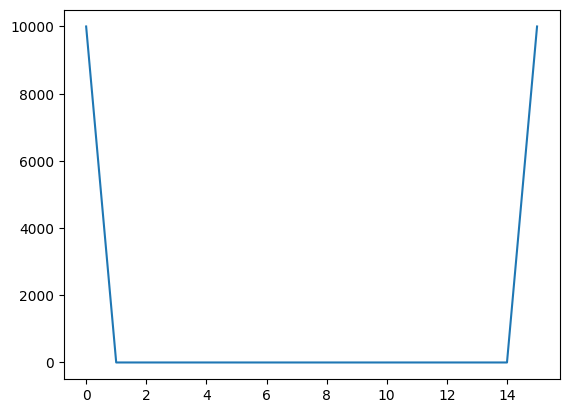

In [23]:
print(len(kernel_weights))
print(kernel_weights)
plot(kernel_weights)

## The black-box model

In this case it is a simple linear model and the model parameters are just randomly generated as an example. We take the synthetic dataset and use the model to get the predicted $y$ values. $y$ is of dimension $16 \times 1$. The model parameters are $\beta = \{\beta_1, \beta_2, \beta_3, \beta_4, \beta_0\}$.

In [24]:
model_params = np.random.rand(M)  # random here, but should be the actual parameters of the bb model
bias = np.random.rand(1).item()
y = model(synthetic_dataset)    # Calling the black-box model
y

array([8.31527354, 8.86063372, 8.2126635 , 8.52269636, 8.40149863,
       8.75802368, 9.06805654, 8.9468588 , 8.42008632, 8.29888859,
       8.60892145, 8.9654465 , 8.84424876, 9.15428163, 8.50631141,
       9.05167159])

## Solve for the coefficients of the minimized kernel-weighted loss function, using weighted least squares regression

https://en.wikipedia.org/wiki/Weighted_least_squares

$$
\phi = [A^\top \cdot W \cdot A]^{-1} \cdot [A^\top \cdot W \cdot y]
$$

- $A$ is of dimension $16 \times 5$
- $B$ is of dimension $16 \times 4$
- $W$ is of dimension $16 \times 16$
- $x$ is of dimension $4 \times 1$
- $y$ is of dimension $16 \times 1$

So, $\phi$ in this case will be of dimension $5 \times 1$.

In [25]:
W = np.diag(kernel_weights)  # create a diagonal matrix W of the shapley_kernel weights
print(W.shape)  # This is a square matrix

(16, 16)


In [26]:
xtwxm1 = np.linalg.inv(np.dot(np.dot(simplified_features.T, W), simplified_features))
print(xtwxm1.shape)
xtwxm1

(5, 5)


array([[ 1.00001250e+00, -3.33320834e-01, -3.33320834e-01,
        -3.33320834e-01, -2.49993750e-05],
       [-3.33320834e-01,  1.00001250e+00, -3.33320834e-01,
        -3.33320834e-01, -2.49993750e-05],
       [-3.33320834e-01, -3.33320834e-01,  1.00001250e+00,
        -3.33320834e-01, -2.49993750e-05],
       [-3.33320834e-01, -3.33320834e-01, -3.33320834e-01,
         1.00001250e+00, -2.49993750e-05],
       [-2.49993750e-05, -2.49993750e-05, -2.49993750e-05,
        -2.49993750e-05,  9.99918760e-05]])

In [27]:
res = np.dot(xtwxm1, np.dot(np.dot(simplified_features.T, W), y))
print(res.shape)
res

(5,)


array([ 0.54536018, -0.10261004,  0.20742282,  0.08622509,  8.31527354])

## Test full function for SHAP values

Here we check that the original model we coded at the top of the notebook is indeed giving the same results as the separate pieces we looked at step by step.

In [28]:
sol = kernel_shap(model, instance, reference, M)
sol

<ipython-input-10-5f3f8fef0577>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  synthetic_dataset[i, subset] = instance[subset]


array([ 0.54536018, -0.10261004,  0.20742282,  0.08622509,  8.31527354])

## Additivity of SHAP values

$$
y = \phi_0 + \sum_{i=1}^M \phi_i = x \cdot \beta
$$

where $x$ is the row of synthetic dataset $B$ with a 1 appended to it. And recall that $\beta$ is the black-box model parameter vector.

In [29]:
# Compute the model value (y) of the instance
print('Instance')
x = append(list(instance),1.0)
print(instance)
print(model(instance))

Instance
sepal.length    6.6
sepal.width     2.9
petal.length    4.6
petal.width     1.3
Name: 58, dtype: object
9.05167158619588


In [30]:
#Cross check that this equals the sum of the SHAP values
sum(sol)

9.051671586182056

The absolute sign of the $\phi$ values tells us which feature is the most relevant in determining the model's predicted value.

In [31]:
# Most important feature (ignore the intercept of course)
print("Most important feature (starting index 0): ", argmax(abs(sol[:M])))

Most important feature (starting index 0):  0


## Using AutoGluon with the SHAP package

Now we will use the iris dataset for ML with AutoGluon and see how to pass the results to SHAP.

In [32]:
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split

In [33]:
iris.head()

sepal.length  sepal.width  petal.length  petal.width variety
0           5.1          3.5           1.4          0.2  Setosa
1           4.9          3.0           1.4          0.2  Setosa
2           4.7          3.2           1.3          0.2  Setosa
3           4.6          3.1           1.5          0.2  Setosa
4           5.0          3.6           1.4          0.2  Setosa

In [34]:
#TRAIN THE MODEL (DATA)

print(iris.columns)

train_data, test_data = train_test_split(iris, test_size=0.3, random_state=42)
print("Train size =",train_data.shape," | Test size =",test_data.shape)

Index(['sepal.length', 'sepal.width', 'petal.length', 'petal.width',
       'variety'],
      dtype='object')
Train size = (105, 5)  | Test size = (45, 5)


In [35]:
#TRAIN THE MODEL (FIT)

predictor = TabularPredictor(label='variety').fit(train_data=train_data)#,    hyperparameters='multimodal')
performance = predictor.evaluate(test_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20250311_152831"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       11.01 GB / 12.67 GB (86.9%)
Disk Space Avail:   64.23 GB / 107.72 GB (59.6%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions 

In [36]:
import shap

train_data_wo_label = train_data.drop(['variety'], axis=1)
test_data_wo_label = test_data.drop(['variety'], axis=1)

labels = [name for name in test_data_wo_label]

# We have to create a data frame everytime we want the data
predict_proba = lambda data : predictor.predict_proba(pd.DataFrame(data, columns=labels)) # a lambda function
explainer = shap.KernelExplainer(model=predict_proba, data=train_data_wo_label, link='logit') # kernel shap function

shap_values = explainer.shap_values(test_data_wo_label, nsamples=50, l1_reg='num_features(10)')

  0%|          | 0/45 [00:00<?, ?it/s]

In [37]:
print(predict_proba)
print(explainer)
print(array(shap_values).shape) # test rows x features x classes

<function <lambda> at 0x7abf3188d120>
(45, 4, 3)


In [38]:
import shap
from numpy import array
from random import randint

# Assuming 'iris', 'explainer', 'shap_values', and 'test_data_wo_label' are already defined

shap.initjs()
j = randint(0, len(test_data_wo_label))
print("Instance# :", j, " | Type =", iris.variety[j])

# Select SHAP values for the first class (class_index = 0)
# You can change this to the desired class index if needed
class_index = 0
shap.force_plot(explainer.expected_value[class_index], shap_values[j, :, class_index], test_data_wo_label.iloc[j,:])

Instance# : 24  | Type = Setosa


In [39]:
# plot the SHAP values for the Setosa output of all instances
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[:,:,0], test_data_wo_label, link="logit")

## Global Explanation

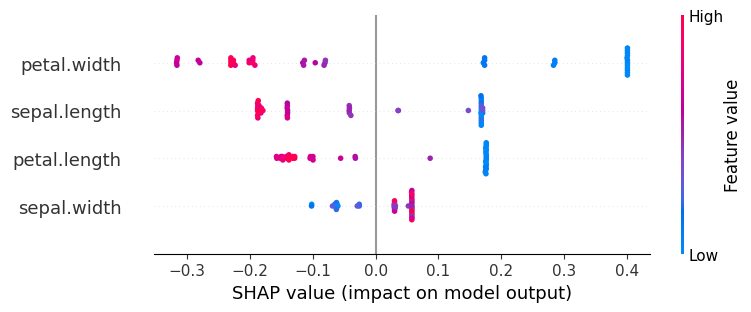

In [40]:
# Classes: ['Versicolor', 'Virginica', 'Setosa']
explanation = shap.Explanation(values=shap_values[:,:,class_index],
                                 data=test_data_wo_label.values,
                                 feature_names=test_data_wo_label.columns,
                                 base_values=explainer.expected_value)

shap.initjs()
# Now use the explanation object for the beeswarm plot
shap.plots.beeswarm(explanation)

## Handling NLP Explainability

We use the Disaster Tweets Dataset (2020): https://www.kaggle.com/vstepanenko/disaster-tweets (open source dataset)

In [41]:
# Read data
df_orig = pd.read_csv('NLP_data/disaster_tweets.csv')
df_orig = df_orig[['target','text']]
df_orig.columns = ["Label","Text"]
print(df_orig.shape)
df_orig.head()

(11370, 2)


Label  \
0      1   
1      1   
2      1   
3      1   
4      0   

                                                                                                                                           Text  
0                 Communal violence in Bhainsa, Telangana. "Stones were pelted on Muslims' houses and some houses and vehicles were set ablaze…  
1           Telangana: Section 144 has been imposed in Bhainsa from January 13 to 15, after clash erupted between two groups on January 12. Po…  
2                                                                               Arsonist sets cars ablaze at dealership https://t.co/gOQvyJbpVI  
3                                                       Arsonist sets cars ablaze at dealership https://t.co/0gL7NUCPlb https://t.co/u1CcBhOWh9  
4  "Lord Jesus, your love brings freedom and pardon. Fill me with your Holy Spirit and set my heart ablaze with your l… https://t.co/VlTznnPNi8

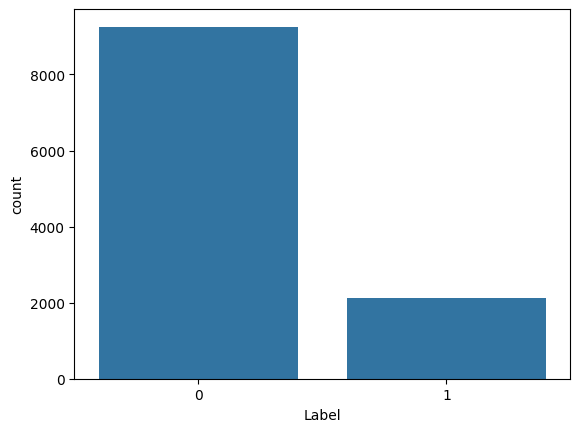

In [42]:
import seaborn as sns
df = df_orig.copy()
sns.countplot(x='Label', data=df)
show()

In [43]:
res = df.groupby('Label').count()
print(res)
print(res/sum(res))

       Text
Label      
0      9256
1      2114
           Text
Label          
0      0.814072
1      0.185928


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [44]:
# !pip install unidecode --quiet
# !pip install gensim==3.6.0 --quiet
# !pip install texthero --no-dependencies
# !pip install --upgrade spacy --quiet

# Use texthero as an alternative text cleaner, instead of the code below

import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')
stopwords = nltk.corpus.stopwords.words("english")

def removeNumbersStr(s):
    for c in range(10):
        n = str(c)
        s = s.replace(n," ")
    return s

def cleanText(text, stem=False, lemm=True, stop=True):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())  # remove stuff
    text = removeNumbersStr(text)
    text = text.split()  # tokenize
    if stop is not None:  # remove stopwords
        text = [word for word in text if word not in stopwords]
    if stem == True:  # stemming
        ps = nltk.stem.porter.PorterStemmer()
        text = [ps.stem(word) for word in text]
    if lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [45]:
# import texthero as hero
# df['cleanText'] = hero.clean(df['Text'])

import re

df["cleanText"] = [cleanText(df.Text[j]) for j in range(len(df.Text))]
print(df.shape)
df.head()

(11370, 3)


Label  \
0      1   
1      1   
2      1   
3      1   
4      0   

                                                                                                                                           Text  \
0                 Communal violence in Bhainsa, Telangana. "Stones were pelted on Muslims' houses and some houses and vehicles were set ablaze…   
1           Telangana: Section 144 has been imposed in Bhainsa from January 13 to 15, after clash erupted between two groups on January 12. Po…   
2                                                                               Arsonist sets cars ablaze at dealership https://t.co/gOQvyJbpVI   
3                                                       Arsonist sets cars ablaze at dealership https://t.co/0gL7NUCPlb https://t.co/u1CcBhOWh9   
4  "Lord Jesus, your love brings freedom and pardon. Fill me with your Holy Spirit and set my heart ablaze with your l… https://t.co/VlTznnPNi8   

                                                                                     cleanText  
0       communal violence bhainsa telangana stone pelted muslim house house vehicle set ablaze  
1                 telangana section imposed bhainsa january clash erupted two group january po  
2                                        arsonist set car ablaze dealership httpstcogoqvyjbpvi  
3                      arsonist set car ablaze dealership httpstco gl nucplb httpstcou ccbhowh  
4  lord jesus love brings freedom pardon fill holy spirit set heart ablaze l httpstcovltznnpni

In [46]:
#TRAIN-TEST DATA
from sklearn.model_selection import train_test_split
df = df.drop(['Text'], axis=1)

train_data, test_data = train_test_split(df, test_size=0.2, random_state=123)
print("Train size =",train_data.shape," | Test size =",test_data.shape)

###
# Adding count vectorizer to make this process a bit easier
###

from sklearn.feature_extraction.text import CountVectorizer

# Set vocab size
vectorizer = CountVectorizer(max_features=500).fit(train_data['cleanText'])
vocab = vectorizer.get_feature_names_out()

train_countvec_text = pd.DataFrame(vectorizer.transform(train_data['cleanText']).toarray(), columns=vocab, index=train_data.index)
test_countvec_text = pd.DataFrame(vectorizer.transform(test_data['cleanText']).toarray(), columns=vocab, index=test_data.index)

train_data = pd.concat([train_data.drop(['cleanText'], axis=1), train_countvec_text], axis=1)
test_data = pd.concat([test_data.drop(['cleanText'], axis=1), test_countvec_text], axis=1)

Train size = (9096, 2)  | Test size = (2274, 2)


In [47]:
%%time
# TRAIN THE MODEL
predictor = TabularPredictor(label='Label').fit(train_data=train_data)
performance = predictor.evaluate(test_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20250311_152907"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.42 GB / 12.67 GB (82.2%)
Disk Space Avail:   64.14 GB / 107.72 GB (59.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions 

[1000]	valid_set's binary_error: 0.110989


	0.8956	 = Validation score   (accuracy)
	3.79s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: LightGBM ...
	0.8923	 = Validation score   (accuracy)
	2.68s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.8659	 = Validation score   (accuracy)
	22.41s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.8714	 = Validation score   (accuracy)
	20.91s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: CatBoost ...
	0.889	 = Validation score   (accuracy)
	15.0s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.8736	 = Validation score   (accuracy)
	26.76s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.8747	 = Validation score   (accuracy)
	24.6s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
No improvement since epoch 6: early stopping
	0.8846	 = Validation score   

CPU times: user 4min 14s, sys: 4.46 s, total: 4min 19s
Wall time: 3min 12s


In [48]:
y_test = test_data['Label']
test_data_nolabel = test_data.drop(labels=['Label'],axis=1)
y_pred = predictor.predict(test_data_nolabel)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
print(perf)

{'accuracy': 0.8874230430958663, 'balanced_accuracy': 0.7490338164251208, 'mcc': 0.5831439057222203, 'f1': 0.632183908045977, 'precision': 0.7801418439716312, 'recall': 0.5314009661835749}


In [49]:
%%time
## SHAP

train_data_wo_label = train_data.drop(['Label'], axis=1)

# Example case with 100 instances
test_data_wo_label = test_data.drop(['Label'], axis=1)[:100]

labels = [name for name in test_data_wo_label]

predict_proba = lambda data : predictor.predict_proba(pd.DataFrame(data, columns=labels))

sampled_background_data = shap.sample(train_data_wo_label, 100)
explainer = shap.KernelExplainer(model=predict_proba, data=shap.kmeans(sampled_background_data,10), link='logit')

shap_values = explainer.shap_values(test_data_wo_label[:100], nsamples=50, l1_reg='num_features(10)')

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.167e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.293e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.593e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 4

CPU times: user 1min 38s, sys: 26.5 s, total: 2min 4s
Wall time: 2min 16s


In [ ]:
test_data

In [ ]:
shap.initjs()
j = randint(0,len(test_data_wo_label))
print("Instance# :",j)
class_index = 0
shap.force_plot(explainer.expected_value[class_index], shap_values[j, :, class_index], test_data_wo_label.iloc[j,:])

In [52]:
shap.initjs()
class_index = 1
shap.force_plot(explainer.expected_value[class_index], shap_values[j, :, class_index], test_data_wo_label.iloc[j,:])

In [53]:
explainer.expected_value.shape

(2,)

In [54]:
len(shap_values[0][j][:50])

2

Summary plot


<ipython-input-55-bef1445691d8>:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,class_index], test_data_wo_label, plot_type="bar")


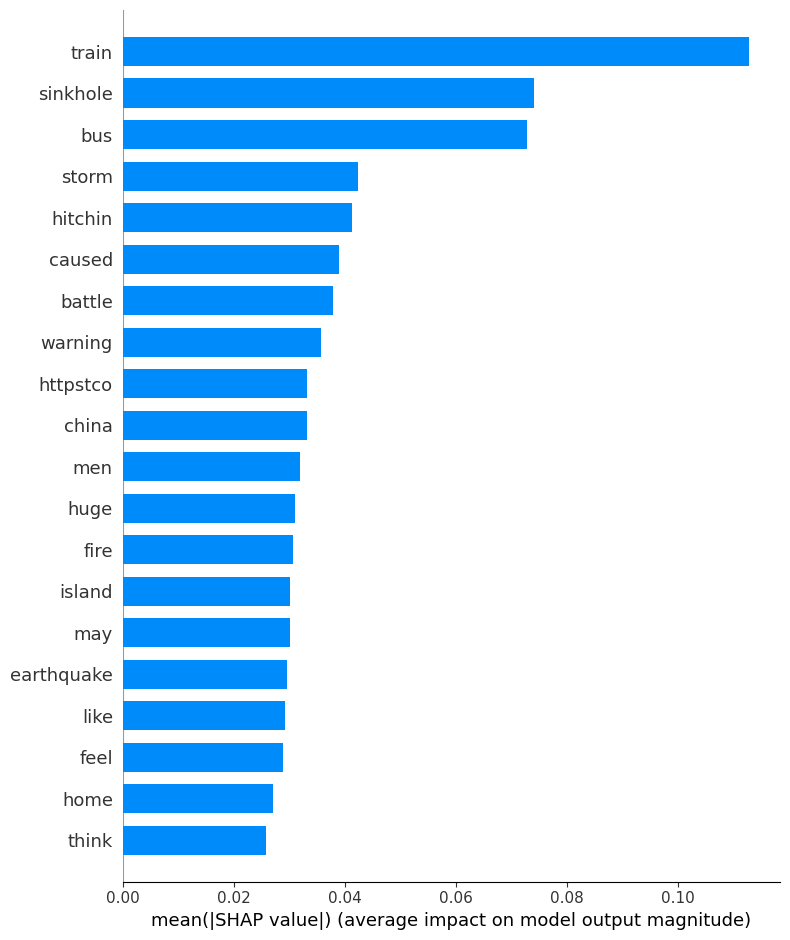

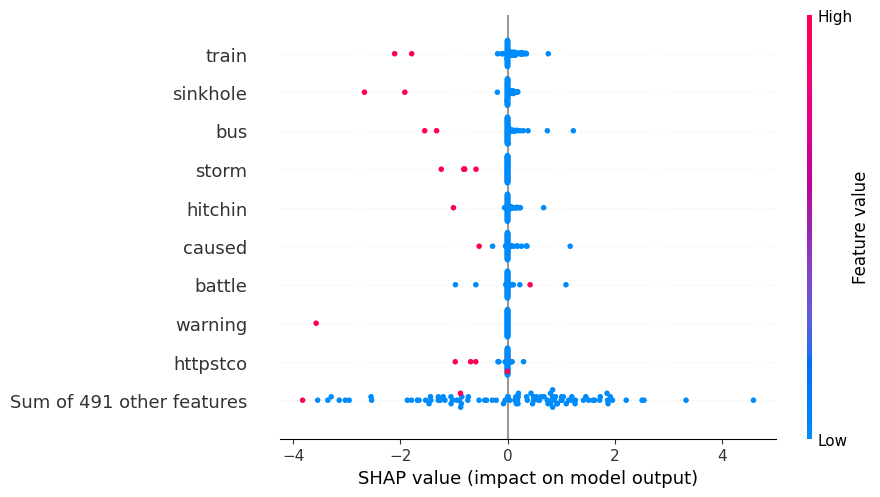

In [55]:
print ("Summary plot")
class_index = 0
shap.summary_plot(shap_values[:,:,class_index], test_data_wo_label, plot_type="bar")
explanation = shap.Explanation(values=shap_values[:,:,class_index],
                                 data=test_data_wo_label.values,
                                 feature_names=test_data_wo_label.columns,
                                 base_values=explainer.expected_value)

shap.initjs()
# Now use the explanation object for the beeswarm plot
shap.plots.beeswarm(explanation)

## AutoGluon XAI using Column Permutations

https://auto.gluon.ai/dev/api/autogluon.tabular.TabularPredictor.feature_importance.html

In [56]:
%%time
feat_imp = predictor.feature_importance(data=test_data, model=None, features=None,
                                    feature_stage='original', subsample_size=1000,
                                    time_limit=500, # number of seconds
                                    num_shuffle_sets=None,
                                    include_confidence_band=True,
                                    confidence_level=0.99, silent=False)

print(feat_imp)

Computing feature importance via permutation shuffling for 500 features using 1000 rows with 10 shuffle sets... Time limit: 500s...
	6780.34s	= Expected runtime (678.03s per shuffle set)
	384.27s	= Actual runtime (Completed 2 of 10 shuffle sets) (Early stopping due to lack of time...)


              importance    stddev   p_value  n  p99_high   p99_low
warning           0.0070  0.001414  0.045167  2  0.070657 -0.056657
sinkhole          0.0060  0.000000  0.500000  2  0.006000  0.006000
year              0.0050  0.002828  0.121119  2  0.132313 -0.122313
thunderstorm      0.0045  0.000707  0.035223  2  0.036328 -0.027328
police            0.0035  0.000707  0.045167  2  0.035328 -0.028328
...                  ...       ...       ... ..       ...       ...
accident         -0.0015  0.000707  0.897584  2  0.030328 -0.033328
httpstco         -0.0015  0.002121  0.750000  2  0.093985 -0.096985
philippine       -0.0020  0.000000  0.500000  2 -0.002000 -0.002000
soldier          -0.0020  0.001414  0.852416  2  0.061657 -0.065657
hour             -0.0025  0.000707  0.937167  2  0.029328 -0.034328

[500 rows x 6 columns]
CPU times: user 8min 22s, sys: 19.4 s, total: 8min 41s
Wall time: 6min 24s


In [ ]:
feat_imp[:10]

## Using Captum from Facebook

https://captum.ai/tutorials/

Facebook has done an incredible job of offering explainability on tabular, image and text models. Please do try and use Captum as much as possible. For NLP, see this example:

https://captum.ai/tutorials/IMDB_TorchText_Interpret


In [ ]:
Image("NLP_images/XAI_CheatSheet.png",width=800)

## LLM XAI

- LLMs are explainable: https://timkellogg.me/blog/2023/10/01/interpretability

- Review SHAP Github: https://github.com/shap/shap

- Review SHAP docs: https://shap.readthedocs.io/en/latest/

## Mechanistic Interpretability

Read: https://seantrott.substack.com/p/mechanistic-interpretability-for

Detailed resource page: https://www.neelnanda.io/mechanistic-interpretability/getting-started

LLMs are often treated as "black boxes" - we can see inputs and outputs, but lack understanding of the internal mechanisms. This is a potential concern as LLMs become more widely deployed, so there is a need to better understand and control their behavior.

Mechanistic interpretability (MI) is the field of study that aims to reverse-engineer neural networks by understanding their internal computations and representations in human-understandable terms. The goal is to go beyond just knowing that a model works, to understanding how it works under the hood.

MI is operationalized in three ways:
1. Classifier probes: Training classifiers on representations from different LLM layers to identify which ones encode particular information.
2. Activation patching: Selectively replacing activations to understand which components are most responsible for predictions.
3. Sparse auto-encoders: Learning a compressed, sparse representation of the LLM's internal workings to make them more interpretable.

There are debates about whether fully mechanistic explanations of LLMs are possible, given their complexity.
Even if feasible, some question whether mechanistic interpretability will actually be the most useful approach for predicting and controlling LLM behavior compared to other methods.

Review papers: https://arxiv.org/abs/2404.14082; https://arxiv.org/abs/2407.02646

See this amazing visualization of LLM interpretability by looking at the internals of the model: https://pair.withgoogle.com/explorables/patchscopes/

Code for MI: https://github.com/TransformerLensOrg/TransformerLens
